# Handling Conditional Discrimination

The paper addresses challenges in removing sensitive attributes for non-discriminatory training, highlighting that a naive approach fails when other attributes correlate with the sensitive one. The study proposes two strategies: 1) removing the relation between the sensitive attribute and the class label, achieved by modifying training labels, and 2) splitting data based on an explanatory attribute, training individual classifiers for each group. The paper adopts the first strategy and introduces two techniques, **local massaging** and **local preferential sampling**, to modify  data labels while satisfying conditional non-discrimination constraints. Local massaging adjusts labels near decision boundaries, considering discrimination impact, while local preferential sampling modifies data composition to eliminate discrimination. Pseudo-codes for both techniques are provide below:

Local massaging

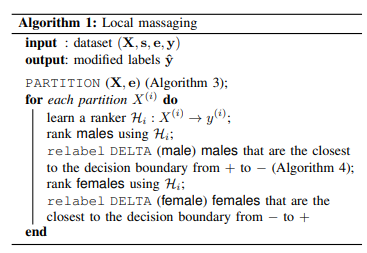:


Local preferential sampling

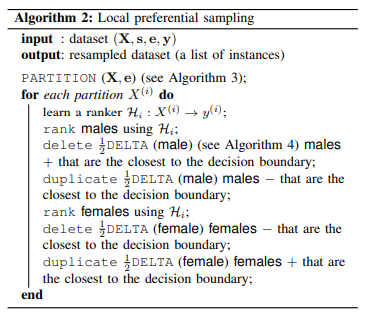


**Our approach**: We analyzed a dataset where the sensitive attribute is race (African-American and Caucasian), explanatory attribute is 'decile score' and outcome variable is two-year recidivism rate. This notebook contains code for local massaging and local preferential sampling techniques, as applied to the dataset. The 'local_massaging' function employs logistic regression to learn a ranker for each partition, identifies individuals close to decision boundaries, and adjusts their labels to reduce discrimination. The adjustments are based on the ranker's output, ensuring a fair representation across different groups, particularly concerning the sensitive attribute (race by default). The function returns the dataset with modified labels after applying local massaging. On the other hand, 'local_pref_samp' function employs logistic regression to learn a ranker for each partition, identifies instances close to decision boundaries, and adjusts the dataset by deleting instances with 'wrong' labels and duplicating instances with 'right' labels - returning the modified dataset. 
 
Our findings indicate a reduction in the difference between recidivism rates for two groups when employing the local massaging method. However, it's worth noting that the observed decrease was not substantial. Despite this, local massaging remains a viable option for this dataset.

## Load The Data 

In [7]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression

import warnings
warnings.filterwarnings('ignore')

data = pd.read_csv("/Users/fiona/Documents/GitHub/Project4-Group7/data/compas-scores-two-years.csv")

In [2]:
# data[data['id'] == 8867]

In [3]:
df_C = data[data['race'] == 'Caucasian']
df_A = data[data['race'] == 'African-American']

C_rate = df_C['two_year_recid'].sum()/df_C.shape[0]
A_rate = df_A['two_year_recid'].sum()/df_A.shape[0]

print(f'recidivated rate for Caucasian = {round(C_rate*100, 2)}%')
print(f'recidivated rate for African-American = {round(A_rate*100, 2)}%')

recidivated rate for Caucasian = 39.36%
recidivated rate for African-American = 51.43%


In [4]:
df_CA = pd.concat([df_C, df_A])
df_CA.reset_index(drop = True, inplace = True)

df_CA_2 = df_CA.copy()

In [5]:
y = df_CA['two_year_recid']
s = df_CA['race']

## PARTITION Function (Algorithm 3)

In [6]:
def PARTITION(df, exp_attr):
    # Find all unique value for the explanatory attribute e
    case_lst = list(set(df[exp_attr]))
    # Create an empty dictionary to store the partitioned dataframe
    X_dict = {}
    
    for case in case_lst:
        temp_df = df[df[exp_attr] == case]
        temp_df.reset_index(drop = True, inplace = True)
        
        X_dict[case] = temp_df
    
    return X_dict

In [7]:
# The column "decile_score" is chosen to be the explanatory attribute e
dic_partition = PARTITION(df_CA, exp_attr = 'decile_score')

In [8]:
dic_partition[1].head()

,id,name,first,last,compas_screening_date,sex,dob,age,age_cat,race,...,v_decile_score,v_score_text,v_screening_date,in_custody,out_custody,priors_count.1,start,end,event,two_year_recid
0,10,elizabeth thieme,elizabeth,thieme,2014-03-16,Female,1976-06-03,39,25 - 45,Caucasian,...,1,Low,2014-03-16,2014-03-15,2014-03-18,0,2,747,0,0
1,16,kortney coleman,kortney,coleman,2013-01-01,Female,1978-08-22,37,25 - 45,Caucasian,...,1,Low,2013-01-01,2013-01-01,2013-01-02,0,1,1186,0,0
2,19,craig gilbert,craig,gilbert,2013-10-30,Female,1968-06-14,47,Greater than 45,Caucasian,...,1,Low,2013-10-30,2014-06-03,2014-11-19,1,0,216,1,1
3,32,russell sottile,russell,sottile,2013-01-25,Male,1973-01-10,43,25 - 45,Caucasian,...,2,Low,2013-01-25,2013-01-24,2013-01-25,1,0,1162,0,0
4,45,mark friedland,mark,friedland,2013-12-30,Male,1960-07-27,55,Greater than 45,Caucasian,...,1,Low,2013-12-30,2013-12-29,2013-12-31,0,1,823,0,0


## DELTA Function (Algorithm 4)

In [9]:
def DELTA(dic_partition):
    # Create an empty dictionary to store the delta value for each race under each decile_score
    dic_delta = {}
    for key, df in dic_partition.items():
        # Crerate another empty dictionary to store the delta value for each race
        dic_C_A = {}
        
        # Create temporary dataframe for different race group
        temp_df_C = df[df['race'] == 'Caucasian']
        temp_df_A = df[df['race'] == 'African-American']
        
        # Obtain the number of people in different races, respectively
        G_C = temp_df_C.shape[0]
        G_A = temp_df_A.shape[0]
        
        # Calculate p⋆(+|ei) according to equation 4 in the paper
        prob_C = temp_df_C['two_year_recid'].sum() / G_C
        prob_A = temp_df_A['two_year_recid'].sum() / G_A
        prob_star = (prob_C + prob_A) / 2
        
        # Compute the absolute difference according to the formula in the pseudo-code of Algorithm 4
        diff_prob_C = abs(prob_C - prob_star)
        diff_prob_A = abs(prob_A - prob_star)
        
        # Store the values for two race groups
        dic_C_A['Caucasian'] = int(round(G_C * diff_prob_C, 0))
        dic_C_A['African-American'] = int(round(G_A * diff_prob_A, 0))
        
        # Store the resulted dictionary dic_C_A to the larger one (dic_delta)
        dic_delta[key] = dic_C_A
        
    return dic_delta

In [10]:
DELTA(dic_partition)

{1: {'Caucasian': 7, 'African-American': 4},
 2: {'Caucasian': 2, 'African-American': 2},
 3: {'Caucasian': 11, 'African-American': 14},
 4: {'Caucasian': 9, 'African-American': 12},
 5: {'Caucasian': 3, 'African-American': 4},
 6: {'Caucasian': 1, 'African-American': 2},
 7: {'Caucasian': 2, 'African-American': 5},
 8: {'Caucasian': 2, 'African-American': 7},
 9: {'Caucasian': 1, 'African-American': 3},
 10: {'Caucasian': 3, 'African-American': 13}}

## Internal Ranker (Logistic Regression)

In [11]:
df_CA.columns

Index(['id', 'name', 'first', 'last', 'compas_screening_date', 'sex', 'dob',
       'age', 'age_cat', 'race', 'juv_fel_count', 'decile_score',
       'juv_misd_count', 'juv_other_count', 'priors_count',
       'days_b_screening_arrest', 'c_jail_in', 'c_jail_out', 'c_case_number',
       'c_offense_date', 'c_arrest_date', 'c_days_from_compas',
       'c_charge_degree', 'c_charge_desc', 'is_recid', 'r_case_number',
       'r_charge_degree', 'r_days_from_arrest', 'r_offense_date',
       'r_charge_desc', 'r_jail_in', 'r_jail_out', 'violent_recid',
       'is_violent_recid', 'vr_case_number', 'vr_charge_degree',
       'vr_offense_date', 'vr_charge_desc', 'type_of_assessment',
       'decile_score.1', 'score_text', 'screening_date',
       'v_type_of_assessment', 'v_decile_score', 'v_score_text',
       'v_screening_date', 'in_custody', 'out_custody', 'priors_count.1',
       'start', 'end', 'event', 'two_year_recid'],
      dtype='object')

In [12]:
def ranker_log_reg(df):
    # Mannually select useful columns that can be utilized in logistic regression
    useful_col = ['sex', 'age', 'juv_fel_count', 'decile_score', 'juv_misd_count', 
              'juv_other_count', 'priors_count', 'c_charge_degree',
              'is_recid', 'is_violent_recid', 'v_decile_score', 'event']
    X = df[useful_col]
    # Use one-hot encoding to trasnfer two variables so that it can be put into the regression model
    X = pd.get_dummies(X, columns = ['sex', 'c_charge_degree'], drop_first = True, dtype = int)
    
    # Obtain the label column
    y = df['two_year_recid']
    
    # Fit the logistic the logistic regression model with iteration time 1000 so that the model can converge
    logistic_reg = LogisticRegression(max_iter = 1000)
    logistic_reg.fit(X, y)
    
    # Obtain the probabilities for each observation
    proba = logistic_reg.predict_proba(X)
    
    # Obtain the probability of categorizing to 1 for each observation
    prob_1_lst = []
    for i in range(proba.shape[0]):
        prob_1_lst.append(proba[i][1])
    
    return prob_1_lst

## Local Massaging (Algorithm 1)

In [13]:
def local_massaging(df, s = 'race', e = 'decile_score', y = 'two_year_recid'):
    
    # Apply Algorithm 3 
    dic_partition = PARTITION(df, exp_attr = e)
    
    # Apply Algorithm 4
    dic_delta = DELTA(dic_partition)
    
    # Extract each partition X^(i)
    for key, df_part in dic_partition.items():
        # learn a ranker (logistic regression)
        df_part['ranker'] = ranker_log_reg(df_part)
        
        # Find the people with race Caucasian
        temp_df_C = df_part[df_part['race'] == 'Caucasian']
        # Sort the Caucasian table according to the ranker from largest to lowest
        sorted_df_C = temp_df_C.sort_values(by = 'ranker', ascending = False)
        # Obtain the number of people needed to be adjusted
        adj_num_C = dic_delta[key]['Caucasian']
        # Find the rows with probability (ranker) smaller than the threshold
        # The threshold should be adjusted
        sub_sorted_df_C = sorted_df_C[sorted_df_C['ranker'] < 0.5]
        # Obtain the list of id for the rows from previous steps
        sub_id_C = list(sub_sorted_df_C.id)
        # Find the id that needed to be adjusted using the result of DELTA function
        change_id_C = sub_id_C[:adj_num_C]
        # Change the label for specific rows
        # Labels are changed from 0 to 1 since Caucasian have lower rate of two_year_recid
        for id_num in change_id_C:
            df.loc[df['id'] == id_num, 'two_year_recid'] = 1
        
        # Similar process is performed as above
        temp_df_A = df_part[df_part['race'] == 'African-American']
        sorted_df_A = temp_df_A.sort_values(by = 'ranker', ascending = True)
        adj_num_A = dic_delta[key]['African-American']
        sub_sorted_df_A = sorted_df_A[sorted_df_A['ranker'] > 0.5]
        sub_id_A = list(sub_sorted_df_A.id)
        change_id_A = sub_id_A[:adj_num_A]
        # Labels are changed from 1 to 0 since African-American have higher rate of two_year_recid
        for id_num in change_id_A:
            df.loc[df['id'] == id_num, 'two_year_recid'] = 0
            
    return df

In [14]:
local_massaging(df_CA)

,id,name,first,last,compas_screening_date,sex,dob,age,age_cat,race,...,v_decile_score,v_score_text,v_screening_date,in_custody,out_custody,priors_count.1,start,end,event,two_year_recid
0,8,edward riddle,edward,riddle,2014-02-19,Male,1974-07-23,41,25 - 45,Caucasian,...,2,Low,2014-02-19,2014-03-31,2014-04-18,14,5,40,1,1
1,10,elizabeth thieme,elizabeth,thieme,2014-03-16,Female,1976-06-03,39,25 - 45,Caucasian,...,1,Low,2014-03-16,2014-03-15,2014-03-18,0,2,747,0,0
2,13,bo bradac,bo,bradac,2013-11-04,Male,1994-06-10,21,Less than 25,Caucasian,...,5,Medium,2013-11-04,2015-01-06,2015-01-07,1,0,428,1,1
3,14,benjamin franc,benjamin,franc,2013-11-26,Male,1988-06-01,27,25 - 45,Caucasian,...,4,Low,2013-11-26,2013-11-25,2013-11-26,0,0,857,0,0
4,16,kortney coleman,kortney,coleman,2013-01-01,Female,1978-08-22,37,25 - 45,Caucasian,...,1,Low,2013-01-01,2013-01-01,2013-01-02,0,1,1186,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6145,10994,jarred payne,jarred,payne,2014-05-10,Male,1985-07-31,30,25 - 45,African-American,...,2,Low,2014-05-10,2015-10-22,2015-10-22,0,0,529,1,1
6146,10995,raheem smith,raheem,smith,2013-10-20,Male,1995-06-28,20,Less than 25,African-American,...,9,High,2013-10-20,2014-04-07,2014-04-27,0,0,169,0,0
6147,10996,steven butler,steven,butler,2013-11-23,Male,1992-07-17,23,Less than 25,African-American,...,5,Medium,2013-11-23,2013-11-22,2013-11-24,0,1,860,0,0
6148,10997,malcolm simmons,malcolm,simmons,2014-02-01,Male,1993-03-25,23,Less than 25,African-American,...,5,Medium,2014-02-01,2014-01-31,2014-02-02,0,1,790,0,0


In [15]:
# [8867, 8223, 9352]
# df[df['id'] == 8867]

In [16]:
df_C_2 = df_CA[df_CA['race'] == 'Caucasian']
df_A_2 = df_CA[df_CA['race'] == 'African-American']

C_rate_2 = df_C_2['two_year_recid'].sum()/df_C.shape[0]
A_rate_2 = df_A_2['two_year_recid'].sum()/df_A.shape[0]

print(f'recidivated rate for Caucasian = {round(C_rate_2*100, 2)}%')
print(f'recidivated rate for African-American = {round(A_rate_2*100, 2)}%')

recidivated rate for Caucasian = 41.04%
recidivated rate for African-American = 50.03%


## Local Preferential Sampling (Algorithm 2)

In [17]:
def local_pref_samp(df, s = 'race', e = 'decile_score', y = 'two_year_recid'):
    
    # Apply Algorithm 3 
    dic_partition = PARTITION(df, exp_attr = e)
    
    # Apply Algorithm 4
    dic_delta = DELTA(dic_partition)
    
    # Extract each partition X^(i)
    for key, df_part in dic_partition.items():
        # learn a ranker (logistic regression)
        df_part['ranker'] = ranker_log_reg(df_part)
        
        temp_df_C = df_part[df_part['race'] == 'Caucasian']
        sorted_df_C = temp_df_C.sort_values(by = 'ranker', ascending = False)
        # Find the value of DELTA(Caucasian)/2
        adj_num_C = int(round(dic_delta[key]['Caucasian']/2, 0))
        
        # delete DELTA(Caucasian)/2 (less Caucasian with label 0)
        sub_sorted_df_C_1 = sorted_df_C[sorted_df_C['ranker'] < 0.5]
        sub_id_C_1 = list(sub_sorted_df_C_1.id)
        ids_to_delete_C = sub_id_C_1[:adj_num_C]
        df = df.drop(df[df['id'].isin(ids_to_delete_C)].index)
        
        # duplicate DELTA(Caucasian)/2 (more Caucasian with label 1)
        sub_sorted_df_C_2 = sorted_df_C[sorted_df_C['ranker'] > 0.5]
        sub_id_C_2 = list(sub_sorted_df_C_2.id)
        if adj_num_C > 0:
            ids_to_dup_C = sub_id_C_2[-adj_num_C:]
        else:
            ids_to_dup_C = []
        rows_to_duplicate_C = df[df['id'].isin(ids_to_dup_C)]
        df = pd.concat([df, rows_to_duplicate_C], ignore_index = True)
        
        
        temp_df_A = df_part[df_part['race'] == 'African-American']
        sorted_df_A = temp_df_A.sort_values(by = 'ranker', ascending = False)
        # Find the value of DELTA(African-American)/2
        adj_num_A = int(round(dic_delta[key]['African-American']/2, 0))
        
        # delete DELTA(African-American)/2 (less African-American with label 1)
        sub_sorted_df_A_1 = sorted_df_A[sorted_df_A['ranker'] > 0.5]
        sub_id_A_1 = list(sub_sorted_df_A_1.id)
        ids_to_delete_A = sub_id_A_1[:adj_num_A]
        df = df.drop(df[df['id'].isin(ids_to_delete_A)].index)
        
        # duplicate DELTA(African-American)/2 (more African-American with label 0)
        sub_sorted_df_A_2 = sorted_df_A[sorted_df_A['ranker'] < 0.5]
        sub_id_A_2 = list(sub_sorted_df_A_2.id)
        if adj_num_A > 0:
            ids_to_dup_A = sub_id_A_2[-adj_num_A:]
        else:
            ids_to_dup_A = []
        rows_to_duplicate_A = df[df['id'].isin(ids_to_dup_A)]
        df = pd.concat([df, rows_to_duplicate_A], ignore_index = True)
        
    return df

In [18]:
new = local_pref_samp(df_CA_2)

In [19]:
df_C_3 = new[new['race'] == 'Caucasian']
df_A_3 = new[new['race'] == 'African-American']

C_rate_3 = df_C_3['two_year_recid'].sum()/df_C_2.shape[0]
A_rate_3 = df_A_3['two_year_recid'].sum()/df_A_2.shape[0]

print(f'recidivated rate for Caucasian = {round(C_rate_3*100, 2)}%')
print(f'recidivated rate for African-American = {round(A_rate_3*100, 2)}%')

recidivated rate for Caucasian = 40.06%
recidivated rate for African-American = 50.57%


## Colclusion

Based on the reuslts above, we can observe that the difference between the recidivated rate for two groups of people becomes smaller when we using the method of local massaging. Thus, local massaging may be a better choice in this case.